Simple implementation of model-free REINFORCE algorithm, which is a policy-gradient based method.
The code procedure is:

1. Initialize policy parameters θ
2. For each episode do:
    2.1. Generate an episode trajectory τ = {(s_1, a_1, r_1), ..., (s_T, a_T, r_T)} by following the policy π_θ
    2.2. For each time step t in the episode do:
    
        2.2.1. Calculate the return G_t = r_{t+1} + γr_{t+2} + ... + γ^(T-t)r_T

        2.2.2. Calculate the gradient of the policy with respect to the parameters θ: ∇_θ log(π_θ(a_t|s_t)) * G_t
        
        2.2.3. Update the policy parameters: θ = θ + α * ∇_θ log(π_θ(a_t|s_t)) * G_t
3. Repeat steps 2-3 until the policy converges or a stopping criterion is met

where 

- θ are the policy parameters.
- π_θ(a_t|s_t) is the probability of taking action a_t in state s_t under policy π parameterized by θ.
- G_t is the return from time step t onwards.
- γ is the discount factor, which balances the importance of immediate and future rewards.
- α is the learning rate, which controls the step size of the gradient ascent update.
- T is the number of time steps in the episode.

In [ ]:
# need a virtual display for rendering in docker
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [135]:
import jax
import jax.numpy as jnp
import gymnasium as gym
import optax
from functools import partial 

env = gym.make('CartPole-v1', render_mode="rgb_array").env


# Define the policy
def policy(state, params):
    W, b = params
    logits = jnp.dot(W, state) + b
    probs = jax.nn.softmax(logits)
    action = jax.random.categorical(jax.random.PRNGKey(0), logits)
    return action, probs

# Define the loss function


def loss(params, rollout):
    A, B, W, b = params
    states, actions, rewards, next_states = rollout

    # Compute log likelihood of actions taken by the policy
    _, action_probs = jax.vmap(policy, in_axes=(0, None))(states, (W, b))
    log_probs = jnp.log(
        jnp.sum(action_probs * jax.nn.one_hot(actions, 2), axis=-1))

    # Compute the loss
    loss = -jnp.mean(log_probs * rewards)

    return loss


# Define the optimizer
optimizer = optax.adam(learning_rate=1e-3)

# Initialize parameters
key = jax.random.PRNGKey(0)
A = jax.random.normal(key, shape=(4, 4))
B = jax.random.normal(key, shape=(4,))
W = jax.random.normal(key, shape=(2, 4))
b = jax.random.normal(key, shape=(2,))

params = (A, B, W, b)

# Define the rollout function


def rollout(params, rng_key, env):
    states = []
    actions = []
    rewards = []
    next_states = []

    A, B, W, b = params
    state, _ = env.reset()
    done = False

    while not done:
        action, probs = policy(state, (W,b))
        print(probs)
        print(action)
        next_state, reward, done, _, _ = env.step(int(action))
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        next_states.append(next_state)
        state = next_state

    return (jnp.stack(states), jnp.array(actions), jnp.array(rewards), jnp.stack(next_states))



4
[0.14785823 0.8521418 ]
1
[0.08323887 0.9167611 ]
1
[0.04545513 0.95454484]
1
[0.02439188 0.97560805]
1
[0.01295572 0.9870443 ]
1
[0.00683623 0.99316376]
1
[0.00358941 0.99641055]
1
[0.00187658 0.99812347]
1
[9.7716798e-04 9.9902284e-01]
1


(Array([[ 0.02627945,  0.04627219, -0.00974073, -0.04700811],
        [ 0.02720489,  0.24153244, -0.0106809 , -0.34274834],
        [ 0.03203554,  0.4368047 , -0.01753586, -0.6387802 ],
        [ 0.04077164,  0.63216674, -0.03031147, -0.9369334 ],
        [ 0.05341497,  0.82768404, -0.04905013, -1.2389848 ],
        [ 0.06996865,  1.0234004 , -0.07382983, -1.5466213 ],
        [ 0.09043666,  1.2193272 , -0.10476226, -1.8613971 ],
        [ 0.11482321,  1.4154303 , -0.1419902 , -2.1846828 ],
        [ 0.1431318 ,  1.611615  , -0.18568386, -2.5176032 ]],      dtype=float32),
 Array([1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32),
 Array([1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32),
 Array([[ 0.02720489,  0.24153244, -0.0106809 , -0.34274834],
        [ 0.03203554,  0.4368047 , -0.01753586, -0.6387802 ],
        [ 0.04077164,  0.63216674, -0.03031147, -0.9369334 ],
        [ 0.05341497,  0.82768404, -0.04905013, -1.2389848 ],
        [ 0.06996865,  1.0234004 , -0.07382983, -1.5466213 ],

In [131]:
# add some test
rollout_fn = jax.tree_util.Partial(rollout, params)
rollout_fn(key, env)

(Array([[ 0.01369617, -0.02302133, -0.04590265, -0.04834723],
        [ 0.01323574,  0.17272775, -0.04686959, -0.3551522 ],
        [ 0.0166903 ,  0.3684837 , -0.05397264, -0.66223824],
        [ 0.02405997,  0.5643134 , -0.0672174 , -0.97141534],
        [ 0.03534624,  0.76026994, -0.08664571, -1.2844334 ],
        [ 0.05055164,  0.95638156, -0.11233438, -1.6029392 ],
        [ 0.06967927,  1.1526395 , -0.14439316, -1.9284277 ],
        [ 0.09273206,  1.3489841 , -0.18296172, -2.262184  ]],      dtype=float32),
 Array([1, 1, 1, 1, 1, 1, 1, 1], dtype=int32),
 Array([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32),
 Array([[ 0.01323574,  0.17272775, -0.04686959, -0.3551522 ],
        [ 0.0166903 ,  0.3684837 , -0.05397264, -0.66223824],
        [ 0.02405997,  0.5643134 , -0.0672174 , -0.97141534],
        [ 0.03534624,  0.76026994, -0.08664571, -1.2844334 ],
        [ 0.05055164,  0.95638156, -0.11233438, -1.6029392 ],
        [ 0.06967927,  1.1526395 , -0.14439316, -1.9284277 ],
      

In [126]:

# Train the model
states_opt = optimizer.init(params)
for i in range(10000):
    key, subkey = jax.random.split(key)
    
    # this seems not working as [env] is not treated as jnp object
    #rollout_fn = jax.jit(partial(rollout, params))
    #rollout_batch = jax.vmap(rollout_fn)(
    #    jax.random.split(subkey, 10), [env] * 10)
    rollout_fn = partial(rollout, params)
    rollout_batch = rollout_fn(key, env)

    grads = jax.grad(loss)(params, rollout_batch)
    updates, states_opt = optimizer.update(grads, states_opt, params)
    params = optax.apply_updates(params, updates)

    if i % 100 == 0:
        print(f'Iteration {i}, loss={loss(params, rollout_batch):.4f}')


Iteration 0, loss=0.0000


KeyboardInterrupt: 

In [127]:
params
len(params)
params[2:]


(Array([[-2.8393521, -1.4376942,  2.60639  ,  3.499308 ],
        [ 1.6443161,  3.1703238, -3.840195 , -0.6995216]], dtype=float32),
 Array([-3.8792114,  3.9508655], dtype=float32))

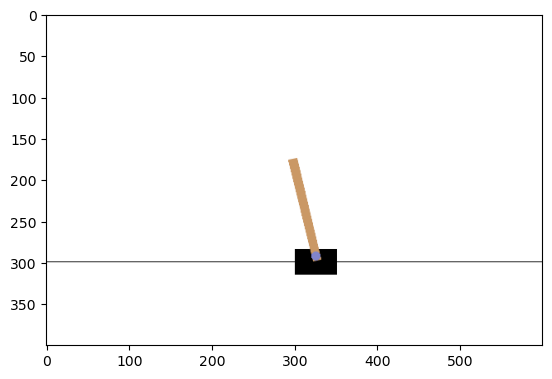

In [137]:
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt 

# Test the model
state, _ = env.reset(seed=10)
done = False
while not done:
    action, _ = policy(state, params[2:])
    state, _, done, _, _ = env.step(int(action))
    screen = env.render()
    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf()) 

ipythondisplay.clear_output(wait=True)
env.close()
